###Set Up Library

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load dataset

In [1]:
df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### EDA

In [3]:
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Data Fields:
- count: (Integer) number of users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable,
- hate_speech_annotation: (Integer) number of users who judged the tweet to be hate speech,
- offensive_language_annotation: (Integer) number of users who judged the tweet to be offensive,
- neither_annotation: (Integer) number of users who judged the tweet to be neither offensive nor non-offensive,
- label: (Class Label) class label for majority of CF users (0: 'hate-speech', 1: 'offensive-language' or 2: 'neither'),
tweet: (string)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [9]:
df.describe()

,count,hate_speech_count,offensive_language_count,neither_count,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [8]:
cols = ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class']

for col in cols:
    print(df[col].value_counts())

count
3    22807
6     1571
4      211
9      167
7       27
Name: count, dtype: int64
hate_speech_count
0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: count, dtype: int64
offensive_language_count
3    13383
2     4246
0     3475
1     2066
6      857
5      369
4      251
9       66
8       37
7       33
Name: count, dtype: int64
neither_count
0    18892
3     2790
1     1694
2     1200
6      103
5       54
4       35
9        5
8        5
7        5
Name: count, dtype: int64
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


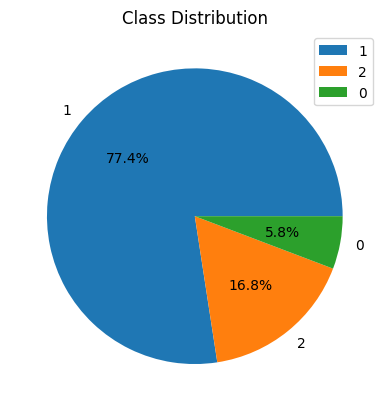

In [17]:
plt.pie(df['class'].value_counts(), labels=df['class'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Distribution')
plt.legend()
plt.show()

**Word count**

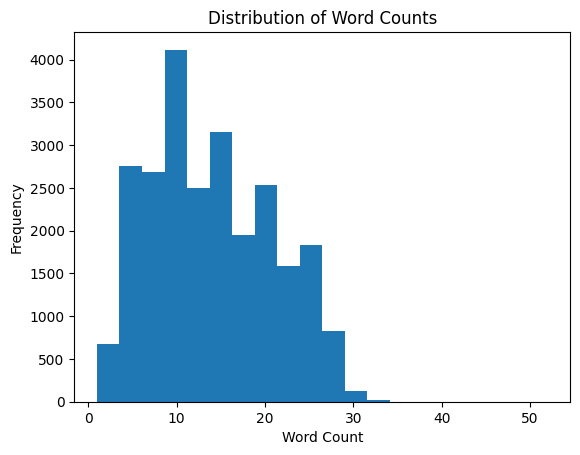

In [21]:
word_count = df['tweet'].apply(lambda x: len(x.split()))

plt.hist(word_count, bins=20)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

**Term frequency analysis**

Clean data:
- lowercase
- stopwords
- usernames
- punctutations

In [39]:
def clean(sample):
    sample = sample.lower()
    sample = re.sub(r'@\w+', '', sample)
    sample = re.sub('[^a-z A-Z 0-9-]+', '', sample)
    sample = " ".join([word for word in sample.split() if word not in stopwords.words('english') and word != 'rt'])

    return sample

In [40]:
df['tweet'] = df['tweet'].apply(lambda x : clean(x))

In [41]:
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,word_count
0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,25
1,3,0,3,0,1,boy dats coldtyga dwn bad cuffin dat hoe 1st p...,16
2,3,0,3,0,1,dawg ever fuck bitch start cry confused shit,21
3,3,0,2,1,1,look like tranny,9
4,6,0,6,0,1,shit hear might true might faker bitch told ya...,26


In [43]:
df['tweet'][1]

'boy dats coldtyga dwn bad cuffin dat hoe 1st place'

In [45]:
def corpus(text):
    text_list = text.split()
    return text_list

In [48]:
df['tweet_lists'] = df['tweet'].apply(corpus)
df.head(10)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,word_count,tweet_lists
0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,25,"[woman, shouldnt, complain, cleaning, house, a..."
1,3,0,3,0,1,boy dats coldtyga dwn bad cuffin dat hoe 1st p...,16,"[boy, dats, coldtyga, dwn, bad, cuffin, dat, h..."
2,3,0,3,0,1,dawg ever fuck bitch start cry confused shit,21,"[dawg, ever, fuck, bitch, start, cry, confused..."
3,3,0,2,1,1,look like tranny,9,"[look, like, tranny]"
4,6,0,6,0,1,shit hear might true might faker bitch told ya...,26,"[shit, hear, might, true, might, faker, bitch,..."
5,3,1,2,0,1,shit blows meclaim faithful somebody still fuc...,19,"[shit, blows, meclaim, faithful, somebody, sti..."
6,3,0,3,0,1,sit hate another bitch got much shit going,20,"[sit, hate, another, bitch, got, much, shit, g..."
7,3,0,3,0,1,8220 cause im tired big bitches coming us skin...,13,"[8220, cause, im, tired, big, bitches, coming,..."
8,3,0,3,0,1,amp might get ya bitch back amp thats,13,"[amp, might, get, ya, bitch, back, amp, thats]"
9,3,1,2,0,1,hobbies include fighting mariambitch,7,"[hobbies, include, fighting, mariambitch]"


In [49]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df['tweet_lists'][i]
len(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 24783/24783 [00:00<00:00, 146578.46it/s]


201057

In [50]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('bitch', 8071),
 ('bitches', 3031),
 ('like', 2749),
 ('hoes', 2313),
 ('pussy', 2058),
 ('im', 2056),
 ('hoe', 1856),
 ('dont', 1742),
 ('8220', 1591),
 ('ass', 1559)]

In [51]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

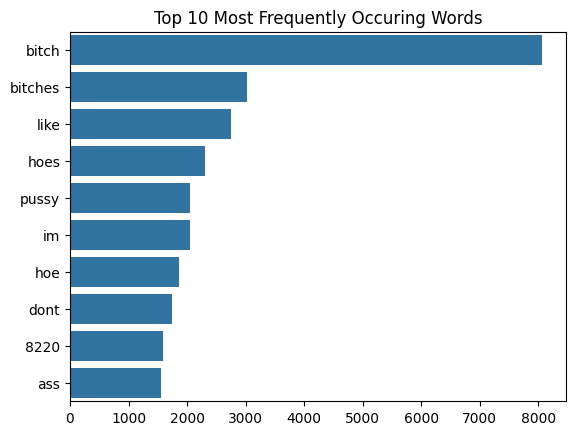

In [52]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

**Most Frequently occuring N_grams**

In [54]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['tweet'])

In [55]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

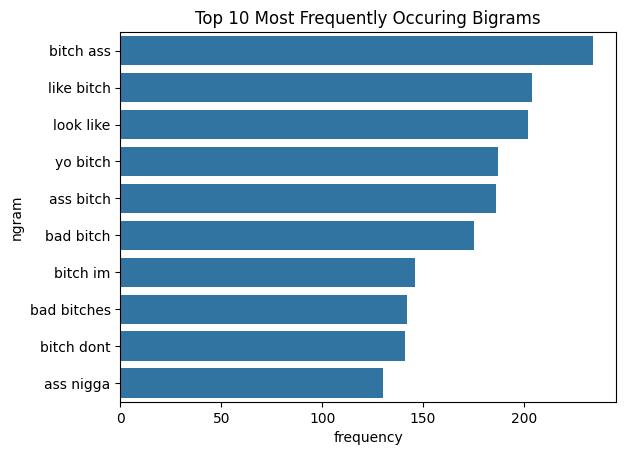

In [56]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()